## Task 7
### Finding eigenvalues with Jacoby method

In [232]:
import numpy as np
from enum import Enum
from math import sqrt
from typing import Tuple, List
import itertools
import matplotlib.pyplot as plt
from scipy import linalg

In [233]:
class PivotStrategy(Enum):
    CYCLE = 'cycle'
    ABS_MAX = 'abs_max'

#### Performs Jaboby rotation
See [Jacoby rotation algorithm](https://en.wikipedia.org/wiki/Jacobi_rotation)

A should be real symmetric matrix. Jacoby rotation doesn't affect eigenvalues spectrum.

$
\begin{align}
\begin{bmatrix}
 {*} &   &   & \cdots &   &   & * \\
   & \ddots &   &   &   &   &   \\
   &   & a_{kk} & \cdots & a_{k\ell} &   &   \\
 \vdots &   & \vdots & \ddots & \vdots &   & \vdots \\
   &   & a_{\ell k} & \cdots & a_{\ell\ell} &   &   \\
   &    &   &   &   & \ddots &   \\
 {*} &   &   & \cdots &   &   & *
\end{bmatrix}
\to
\begin{bmatrix}
 {*} &   &   & \cdots &   &   & * \\
   & \ddots &   &   &   &   &   \\
   &   & a'_{kk} & \cdots & 0 &   &   \\
 \vdots &   & \vdots & \ddots & \vdots &   & \vdots \\
   &   & 0 & \cdots & a'_{\ell\ell} &   &   \\
   &    &   &   &   & \ddots &   \\
 {*} &   &   & \cdots &   &   & *
\end{bmatrix}
\end{align}
$


In [234]:
def rotate(a_matrix: np.ndarray, index: Tuple[int, int]):
    i, j = index
    n = a_matrix.shape[0]

    matrix_ii = a_matrix[i][i]
    matrix_ij = a_matrix[i][j]
    matrix_jj = a_matrix[j][j]

    x = -2 * matrix_ij
    y = matrix_ii - matrix_jj

    if y == 0:
        cos_phi = sqrt(2) / 2
        sin_phi = sqrt(2) / 2
    else:
        cos_phi = sqrt(1 / 2 * (1 + abs(y) / sqrt(x ** 2 + y ** 2)))
        sin_phi = np.sign(x * y) * abs(x) / (2 * cos_phi * sqrt(x ** 2 + y ** 2))

    a_matrix[i][i] = cos_phi ** 2 * matrix_ii - 2 * sin_phi * cos_phi * matrix_ij + sin_phi ** 2 * matrix_jj
    a_matrix[j][j] = sin_phi ** 2 * matrix_ii + 2 * sin_phi * cos_phi * matrix_ij + cos_phi ** 2 * matrix_jj

    a_matrix[i][j] = 0
    a_matrix[j][i] = 0

    for k in range(n):
        if k != i and k != j:
            matrix_ik, matrix_jk = a_matrix[i][k], a_matrix[j][k]

            a_matrix[i][k] = cos_phi * matrix_ik - sin_phi * matrix_jk
            a_matrix[k][i] = cos_phi * matrix_ik - sin_phi * matrix_jk

            a_matrix[j][k] = sin_phi * matrix_ik + cos_phi * matrix_jk
            a_matrix[k][j] = sin_phi * matrix_ik + cos_phi * matrix_jk


In [235]:
def get_circle_radius(matrix: np.ndarray, row_index: int) -> float:
    return abs(matrix[row_index]).sum() - abs(matrix[row_index][row_index])

#### Checks that found eigenvalues satisfy Gershgorin Theorem

D($a_{ii}$, $R_i$) $\subseteq \Complex$ be a closed circle centered at $a_{ii}$ with radius $R_{i}$. Such a circle is called a Gershgorin circle.

Every eigenvalue of A lies within at least one of the Gershgorin circles D($a_{ii}$,$R_{i}$)

In [236]:
def check_gershgorin_theorem(matrix: np.ndarray, eigenvalues: np.ndarray) -> bool:
    gerhgorin_circles = get_gershgorin_circles(matrix)
    n = matrix.shape[0]
    print("Gershgorin circles: ", gerhgorin_circles)
    return all(any(check_eigenvalue_in_circle(circle, eigenvalue) for circle in gerhgorin_circles) for eigenvalue in eigenvalues)

def get_gershgorin_circles(matrix: np.ndarray) -> List[Tuple[float, float]]:
    circles = []
    n = matrix.shape[0]
    for i in range(n):
        radius = get_circle_radius(matrix, i)
        center = matrix[i][i]
        circles.append((center - radius, center + radius))
    return circles

def check_eigenvalue_in_circle(circle: Tuple[float, float], eigenvalue: float) -> bool:
    return circle[0] < eigenvalue < circle[1]

#### Finds modula maximum non diagonal matrix element to be rotation pivot

In [237]:
def find_abs_max_index(matrix: np.ndarray) -> Tuple[int, int]:
    matrix = matrix - np.diag(np.diag(matrix))
    return np.unravel_index(np.argmax(abs(matrix)), matrix.shape)

#### Gets next element in cycle iteration to be rotation pivot

In [238]:
def get_line_by_line_indices(n):
    indicies = []
    for i in range(n):
        for j in range(n):
            if i != j:
                indicies.append((i, j))
    return itertools.cycle(indicies)

### Finds matrix eigenvalues with given error by reducing circle radiuses with Jacoby rotations

In [239]:
def find_eigenvalues(
        matrix: np.ndarray,
        eps: float,
        strategy: PivotStrategy,
        limit: int = 10000,
) -> Tuple[np.ndarray, int]:
    n = matrix.shape[0]
    circle_indicies = get_line_by_line_indices(n)

    for i in range(1, limit):
        if all(get_circle_radius(matrix, i) < eps for i in range(n)):
            return np.diag(matrix), i
        if strategy is PivotStrategy.CYCLE:
            index = next(circle_indicies)
        elif strategy is PivotStrategy.ABS_MAX:
            index = find_abs_max_index(matrix)
        
        rotate(matrix, index)

    return np.diag(matrix), i

In [240]:
def run_test(
        a_matrix: np.ndarray,
        strategy: PivotStrategy
):
    epsilons = []
    steps = []
    eigenvalues = np.zeros(1)

    for i in range (-2, -20, -1):
        eps = 10 ** i
        epsilons.append(eps)
        eigenvalues, iterations = find_eigenvalues(np.copy(a_matrix), eps, strategy)
        steps.append(iterations)
    
    sorted_real_eigenvalues = sorted(np.linalg.eig(a_matrix)[0])

    sorted_eigen_values = sorted(eigenvalues)

    print("Found eigenvalues: \n", sorted_eigen_values)
    print("Real eigenvalues: \n", sorted_real_eigenvalues)

    print("Found correct eigenvalues" if np.allclose(sorted_eigen_values, sorted_real_eigenvalues) else "Fail! Found incorrect eigenvalues")

    gershgorin_theorem_check = check_gershgorin_theorem(a_matrix, eigenvalues)
    print("Passed Gershgorin Theorem check" if gershgorin_theorem_check else "Failed Gershgorin Theorem check")

    plt.figure(figsize=(6, 3))
    plt.plot(epsilons, steps, label='Steps to find value with epsilon', color='red')
    plt.xscale('log')
    plt.xlabel('epsilon')
    plt.ylabel('steps')
    plt.grid()
    plt.show()

### Test 1
#### Hilbert Matrix

A matrix: 
 [[1.         0.5        0.33333333 0.25       0.2       ]
 [0.5        0.33333333 0.25       0.2        0.16666667]
 [0.33333333 0.25       0.2        0.16666667 0.14285714]
 [0.25       0.2        0.16666667 0.14285714 0.125     ]
 [0.2        0.16666667 0.14285714 0.125      0.11111111]]
Results for abs max element pivot strategy:
Found eigenvalues: 
 [3.287928772167279e-06, 0.00030589804015118053, 0.011407491623419808, 0.2085342186110133, 1.5670506910982311]
Real eigenvalues: 
 [3.287928772179235e-06, 0.00030589804015118373, 0.011407491623419775, 0.2085342186110133, 1.5670506910982296]
Found correct eigenvalues
Gershgorin circles:  [(-0.2833333333333332, 2.283333333333333), (-0.7833333333333334, 1.45), (-0.6928571428571428, 1.0928571428571427), (-0.5988095238095239, 0.8845238095238095), (-0.5234126984126983, 0.7456349206349207)]
Passed Gershgorin Theorem check


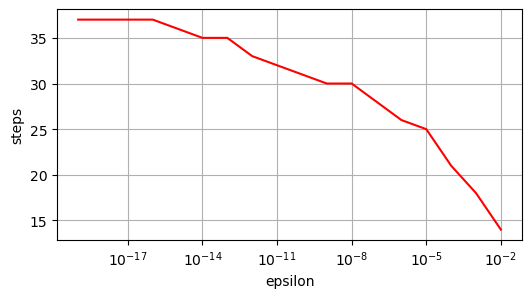

Results for cycle pivot strategy:
Found eigenvalues: 
 [3.2879287721636926e-06, 0.00030589804015118086, 0.011407491623419802, 0.20853421861101334, 1.5670506910982316]
Real eigenvalues: 
 [3.287928772179235e-06, 0.00030589804015118373, 0.011407491623419775, 0.2085342186110133, 1.5670506910982296]
Found correct eigenvalues
Gershgorin circles:  [(-0.2833333333333332, 2.283333333333333), (-0.7833333333333334, 1.45), (-0.6928571428571428, 1.0928571428571427), (-0.5988095238095239, 0.8845238095238095), (-0.5234126984126983, 0.7456349206349207)]
Passed Gershgorin Theorem check


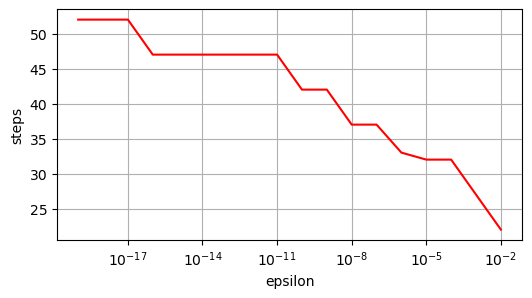

In [241]:
a_matrix = linalg.hilbert(5)
print("A matrix: \n", a_matrix)


print("Results for abs max element pivot strategy:")
run_test(a_matrix, PivotStrategy.ABS_MAX)

print("Results for cycle pivot strategy:")
run_test(a_matrix, PivotStrategy.CYCLE)

### Test 2
#### Big Hilbert matrix

A matrix: 
 [[1.         0.5        0.33333333 0.25       0.2        0.16666667
  0.14285714 0.125      0.11111111 0.1       ]
 [0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
  0.125      0.11111111 0.1        0.09090909]
 [0.33333333 0.25       0.2        0.16666667 0.14285714 0.125
  0.11111111 0.1        0.09090909 0.08333333]
 [0.25       0.2        0.16666667 0.14285714 0.125      0.11111111
  0.1        0.09090909 0.08333333 0.07692308]
 [0.2        0.16666667 0.14285714 0.125      0.11111111 0.1
  0.09090909 0.08333333 0.07692308 0.07142857]
 [0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909
  0.08333333 0.07692308 0.07142857 0.06666667]
 [0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
  0.07692308 0.07142857 0.06666667 0.0625    ]
 [0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
  0.07142857 0.06666667 0.0625     0.05882353]
 [0.11111111 0.1        0.09090909 0.08333333 0.07692308 0.07142857
  0.06666667

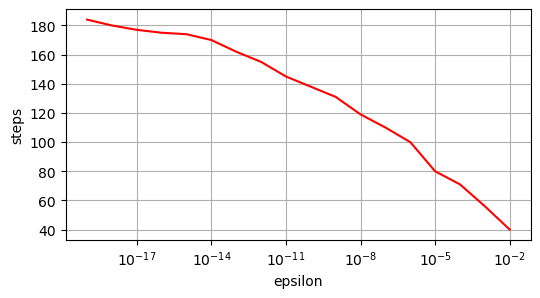

Results for cycle pivot strategy:
Found eigenvalues: 
 [1.0930642659696194e-13, 2.2667461920202833e-11, 2.1474388053394796e-09, 1.2289677387388602e-07, 4.729689293192203e-06, 0.00012874961427635555, 0.002530890768670015, 0.03574181627163923, 0.34292954848350926, 1.7519196702651798]
Real eigenvalues: 
 [1.0932278619527542e-13, 2.266745535619844e-11, 2.147438821759367e-09, 1.2289677387023343e-07, 4.729689293188484e-06, 0.0001287496142763723, 0.002530890768670006, 0.03574181627163922, 0.34292954848350965, 1.7519196702651785]
Found correct eigenvalues
Gershgorin circles:  [(-0.9289682539682538, 2.9289682539682538), (-1.3532106782106785, 2.019877344877345), (-1.203210678210678, 1.6032106782106779), (-1.0610861360861361, 1.3468004218004217), (-0.9460067710067708, 1.168228993228993), (-0.8530774780774781, 1.03489565989566), (-0.7768828393828393, 0.930728993228993), (-0.7133620464502818, 0.8466953797836151), (-0.6596038765156412, 0.7772509353391707), (-0.6135082452806913, 0.718771403175428)]
P

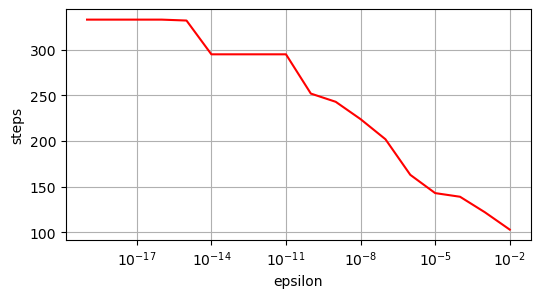

In [244]:
a_matrix = linalg.hilbert(10)
print("A matrix: \n", a_matrix)


print("Results for abs max element pivot strategy:")
run_test(a_matrix, PivotStrategy.ABS_MAX)

print("Results for cycle pivot strategy:")
run_test(a_matrix, PivotStrategy.CYCLE)